In [8]:
from google.colab import files
uploaded = files.upload()

Saving HI-Small_Trans.csv to HI-Small_Trans.csv


In [9]:
import io
import pandas as pd

df2 = pd.read_csv(io.BytesIO(uploaded['HI-Small_Trans.csv']))

In [10]:
df2.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [11]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [12]:
df2.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

In [13]:
# --------------------------- Data Preprocessing --------------------------- #
# Convert 'Timestamp' to datetime
df2["Timestamp"] = pd.to_datetime(df2["Timestamp"])
df = df2.sort_values(by="Timestamp")

In [14]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
316720,2022-09-01,121,8123FB9B0,121,8123FB9B0,47.64,Saudi Riyal,47.64,Saudi Riyal,Reinvestment,0
261688,2022-09-01,25170,8095AF7C0,25170,8095AF7C0,3917.42,Canadian Dollar,3917.42,Canadian Dollar,Reinvestment,0
261696,2022-09-01,25665,809A7D4B0,24779,809189BA0,97.49,Canadian Dollar,97.49,Canadian Dollar,Credit Card,0
126680,2022-09-01,32317,800D4E490,12004,800D4E750,13939.05,Euro,13939.05,Euro,Wire,0
126564,2022-09-01,1024,800C8D9D0,1024,800C8D9D0,10.37,Euro,10.37,Euro,Reinvestment,0


In [15]:
# Rename columns for better handling
df.rename(columns={
    "From Bank": "Sender_Bank",
    "Account": "Sender_Account",
    "To Bank": "Receiver_Bank",
    "Account.1": "Receiver_Account",
    "Amount Received": "Amount_Received",
    "Receiving Currency": "Receiving_Currency",
    "Amount Paid": "Amount_Paid",
    "Payment Currency": "Payment_Currency",
    "Payment Format": "Payment_Format",
    "Is Laundering": "Is_Laundering"
}, inplace=True)

In [16]:
# Fill missing values (categorical: mode, numerical: median)
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

<ipython-input-16-b362ff0f84f6>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
<ipython-input-16-b362ff0f84f6>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [17]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Encoding categorical variables
categorical_cols = ["Sender_Bank", "Receiver_Bank", "Receiving_Currency", "Payment_Currency", "Payment_Format"]
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [18]:
print(df.isnull().sum())

Timestamp             0
Sender_Bank           0
Sender_Account        0
Receiver_Bank         0
Receiver_Account      0
Amount_Received       0
Receiving_Currency    0
Amount_Paid           0
Payment_Currency      0
Payment_Format        0
Is_Laundering         0
dtype: int64


In [19]:
print('Amount Received equals to Amount Paid:')
print(df['Amount_Received'].equals(df['Amount_Paid']))
print('Receiving Currency equals to Payment Currency:')
print(df['Receiving_Currency'].equals(df['Payment_Currency']))

Amount Received equals to Amount Paid:
False
Receiving Currency equals to Payment Currency:
False


In [20]:
import numpy as np
# --------------------------- Feature Engineering --------------------------- #
# 1️⃣ Transaction-Based Features
#transaction_amount_log: Log transformation for better scaling
#rolling_avg_amount_7d: Average transaction amount over the last 7 days
#rolling_std_amount_7d: Standard deviation of transactions over the last 7 days

df["Transaction_Difference"] = df["Amount_Paid"] - df["Amount_Received"]
df["Transaction_Difference_Percentage"] = df["Transaction_Difference"] / df["Amount_Paid"]
df["Transaction_Difference_Percentage"].fillna(0, inplace=True)

# Log transformation to handle skewness in amounts
df["log_Amount_Received"] = np.log1p(df["Amount_Received"])
df["log_Amount_Paid"] = np.log1p(df["Amount_Paid"])

# Rolling statistics (last 7 days)
df["Rolling_Mean_Amount_7D"] = df.groupby("Sender_Account")["Amount_Paid"].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df["Rolling_Std_Amount_7D"] = df.groupby("Sender_Account")["Amount_Paid"].transform(
    lambda x: x.rolling(7, min_periods=1).std()
)

<ipython-input-20-e3e25cc40772>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Transaction_Difference_Percentage"].fillna(0, inplace=True)


In [21]:
# 2️⃣ Time-Based Features
#hour_of_transaction: Transaction hour (to detect unusual times)
#day_of_week: Day of the week (0=Monday, 6=Sunday)
#is_weekend: Whether the transaction happened on a weekend

df["Hour"] = df["Timestamp"].dt.hour
df["Day_of_Week"] = df["Timestamp"].dt.dayofweek
df["Is_Weekend"] = df["Day_of_Week"].apply(lambda x: 1 if x >= 5 else 0)

In [22]:
df.head()

,Timestamp,Sender_Bank,Sender_Account,Receiver_Bank,Receiver_Account,Amount_Received,Receiving_Currency,Amount_Paid,Payment_Currency,Payment_Format,Is_Laundering,Transaction_Difference,Transaction_Difference_Percentage,log_Amount_Received,log_Amount_Paid,Rolling_Mean_Amount_7D,Rolling_Std_Amount_7D,Hour,Day_of_Week,Is_Weekend
316720,2022-09-01,34,8123FB9B0,34,8123FB9B0,47.64,8,47.64,8,5,0,0.0,0.0,3.884446,3.884446,47.64,NaN,0,3,0
261688,2022-09-01,909,8095AF7C0,709,8095AF7C0,3917.42,3,3917.42,3,5,0,0.0,0.0,8.273444,8.273444,3917.42,NaN,0,3,0
261696,2022-09-01,918,809A7D4B0,698,809189BA0,97.49,3,97.49,3,4,0,0.0,0.0,4.589955,4.589955,97.49,NaN,0,3,0
126680,2022-09-01,1744,800D4E490,433,800D4E750,13939.05,4,13939.05,4,6,0,0.0,0.0,9.542521,9.542521,13939.05,NaN,0,3,0
126564,2022-09-01,53,800C8D9D0,53,800C8D9D0,10.37,4,10.37,4,5,0,0.0,0.0,2.430978,2.430978,10.37,NaN,0,3,0


In [23]:
# 3️⃣ Behavior-Based Features
#num_transactions_30d: Number of transactions in the last 30 days
#avg_transaction_amount_30d: Mean transaction amount over 30 days

df["Num_Transactions_30D"] = df.groupby("Sender_Account")["Amount_Paid"].transform(
    lambda x: x.rolling(30, min_periods=1).count()
)
df["Avg_Transaction_30D"] = df.groupby("Sender_Account")["Amount_Paid"].transform(
    lambda x: x.rolling(30, min_periods=1).mean()
)

In [24]:
import networkx as nx
# 4️⃣ Network-Based Features (Using Graphs)
#degree_centrality: Number of connections an account has
#pagerank_score: Importance of an account in the transaction network

G = nx.from_pandas_edgelist(df, source="Sender_Account", target="Receiver_Account")

# Degree centrality (number of connections)
degree_centrality = nx.degree_centrality(G)
df["Degree_Centrality"] = df["Sender_Account"].map(degree_centrality)

# PageRank Score
pagerank = nx.pagerank(G)
df["PageRank_Score"] = df["Sender_Account"].map(pagerank)

In [25]:
# 5️⃣ Currency-Based Features
#cross_country_transaction: Flag for international transactions

df["Cross_Currency_Transaction"] = df.apply(lambda x: 1 if x["Receiving_Currency"] != x["Payment_Currency"] else 0, axis=1)

In [26]:
# 6️⃣ Scaling Numerical Features
scaler = StandardScaler()
num_features = [
    "Amount_Received", "Amount_Paid", "Transaction_Difference", "Transaction_Difference_Percentage",
    "Rolling_Mean_Amount_7D", "Rolling_Std_Amount_7D", "Num_Transactions_30D",
    "Degree_Centrality", "PageRank_Score"
]
df[num_features] = scaler.fit_transform(df[num_features])

In [27]:
# Save processed data
df.to_csv("IBM_AML_Preprocessed.csv", index=False)

print("Data preprocessing and feature engineering completed!")

Data preprocessing and feature engineering completed!


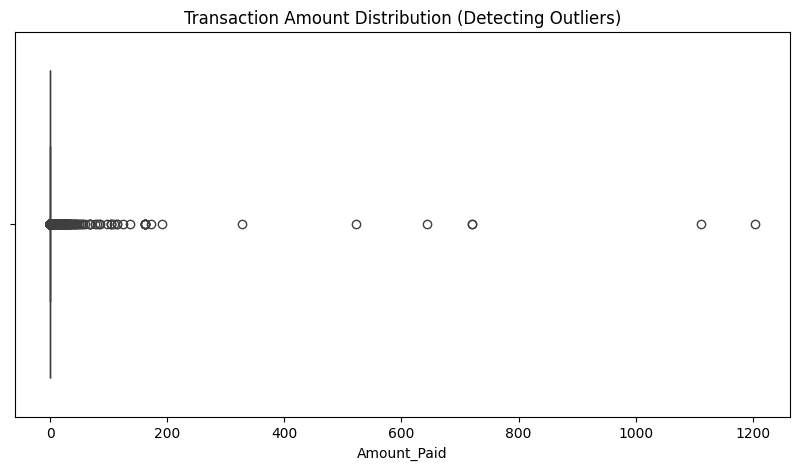

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
df = pd.read_csv("IBM_AML_Preprocessed.csv")

# 🔹 Convert columns to correct data types
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors='coerce')  # Convert to datetime
df["Amount_Paid"] = pd.to_numeric(df["Amount_Paid"], errors='coerce')  # Convert to float
df["Amount_Received"] = pd.to_numeric(df["Amount_Received"], errors='coerce')  # Convert to float

# 1️⃣ Detect Rapid Transaction Bursts (Velocity Analysis)
df["Time_Diff"] = df.groupby("Sender_Account")["Timestamp"].diff().dt.total_seconds()
df["Is_Burst"] = df["Time_Diff"].apply(lambda x: 1 if pd.notna(x) and x < 60 else 0)  # Transactions < 1 min apart

# 2️⃣ Unusual Amounts (Amount Deviation)
df["Z_Score_Amount"] = (df["Amount_Paid"] - df["Amount_Paid"].mean()) / df["Amount_Paid"].std()
df["Is_Anomalous_Amount"] = df["Z_Score_Amount"].apply(lambda x: 1 if abs(x) > 3 else 0)  # Flag outliers beyond 3 std

# 3️⃣ Detect Circular Transactions (Same sender & receiver)
df["Is_Circular"] = df.apply(lambda x: 1 if x["Sender_Account"] == x["Receiver_Account"] else 0, axis=1)

# 4️⃣ Currency Arbitrage (Different currencies)
df["Currency_Arbitrage"] = df.apply(lambda x: 1 if x["Receiving_Currency"] != x["Payment_Currency"] else 0, axis=1)

# Visualize anomalies
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["Amount_Paid"])
plt.title("Transaction Amount Distribution (Detecting Outliers)")
plt.show()


In [29]:
# Save flagged transactions
df.to_csv("Behavioral_Analysis_Results.csv", index=False)
print("Behavioral analysis completed! Flags added.")

Behavioral analysis completed! Flags added.


In [30]:
pip install python-louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9459 sha256=d5b63de26e4a5fd20519ef3aef78d44dc6bc74a5c7dda5ff268935005aa2f97d
  Stored in directory: /root/.cache/pip/wheels/11/c1/e7/f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain


In [31]:
import networkx as nx
import pandas as pd
import numpy as np
from community import community_louvain
from tqdm import tqdm  # Progress bar for large computations

# Load dataset (ensure it is preprocessed correctly)
df = pd.read_csv("IBM_AML_Preprocessed.csv")

# Create a directed graph for transaction flow
G = nx.from_pandas_edgelist(df, source="Sender_Account", target="Receiver_Account", edge_attr="Amount_Paid", create_using=nx.DiGraph())

## **1️⃣ Approximate Degree Centrality (Faster)**
degree_centrality = dict(G.in_degree())  # Only in-degree (receiving transactions)
df["Degree_Centrality"] = df["Sender_Account"].map(degree_centrality)

## **2️⃣ Approximate PageRank (Faster Computation)**
pagerank_scores = nx.pagerank(G, alpha=0.85, max_iter=50)  # Limits iterations to 50 for speed
df["PageRank_Score"] = df["Sender_Account"].map(pagerank_scores)

## **3️⃣ Community Detection with Sampling (Louvain)**
# Instead of processing the entire graph, we process a **reduced subgraph** of active accounts
subgraph_nodes = set(df["Sender_Account"].sample(n=min(5000, len(df)), random_state=42))  # Sample 5000 nodes
G_sub = G.subgraph(subgraph_nodes)

partition = community_louvain.best_partition(G_sub.to_undirected())
df["Community_ID"] = df["Sender_Account"].map(partition).fillna(-1)  # Assign -1 to accounts not in the sample

## **4️⃣ Efficient Cycle Detection (Only for Suspicious Accounts)**
# Instead of detecting cycles for the whole graph, we check only high-risk nodes (based on PageRank score)
high_risk_accounts = df[df["PageRank_Score"] > df["PageRank_Score"].quantile(0.95)]["Sender_Account"].unique()
cycles_detected = set()

for account in tqdm(high_risk_accounts, desc="Detecting Cycles"):
    if account in G:
        try:
            cycles = list(nx.find_cycle(G, source=account, orientation="original"))  # Faster than `simple_cycles`
            if len(cycles) > 0:
                cycles_detected.add(account)
        except nx.NetworkXNoCycle:
            continue  # No cycle found

df["Is_Cyclic_Transaction"] = df["Sender_Account"].apply(lambda x: 1 if x in cycles_detected else 0)


Detecting Cycles: 100%|██████████| 76/76 [00:00<00:00, 52575.80it/s]


In [32]:
# Save graph-based features
df.to_csv("Graph_Analysis_Optimized.csv", index=False)

print("✅ Optimized Graph Analysis Completed!")

✅ Optimized Graph Analysis Completed!


In [33]:
pip install torch torchvision torch-geometric networkx pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.5/232.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 22.2 MB/s eta 0:00:00


In [34]:
#GNN Graph analysis
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import numpy as np

# Load preprocessed data
df = pd.read_csv("IBM_AML_Preprocessed.csv")

# 1️⃣ Create the Directed Graph for Transaction Network
G = nx.from_pandas_edgelist(df, source="Sender_Account", target="Receiver_Account", edge_attr="Amount_Paid", create_using=nx.DiGraph())

# 2️⃣ Map Accounts to Numeric Indices (for GNN compatibility)
account_mapping = {account: idx for idx, account in enumerate(G.nodes())}
df["Sender_Account_Index"] = df["Sender_Account"].map(account_mapping)
df["Receiver_Account_Index"] = df["Receiver_Account"].map(account_mapping)

# 3️⃣ Define Node Features (e.g., Account-based features)
node_features = {}
for node in G.nodes():
    node_features[node] = np.array([G.degree(node), np.mean([G[u][v]['Amount_Paid'] for u, v in G.edges(node)]) if len(list(G.edges(node))) > 0 else 0])  # Avoid empty edge list for mean

# Convert the node features to a torch tensor
node_feature_matrix = torch.tensor(list(node_features.values()), dtype=torch.float)

# 4️⃣ Build Edge Index (for PyG)
# Ensure numeric indices for edge index
edge_index = torch.tensor([(account_mapping[src], account_mapping[tgt]) for src, tgt in G.edges()], dtype=torch.long).t().contiguous()

# 5️⃣ Define Labels (1 for fraud, 0 for normal)
# For simplicity, we set labels randomly. In your case, labels would come from your dataset.
labels = torch.randint(0, 2, (len(G.nodes()),), dtype=torch.long)

# 6️⃣ Create PyTorch Geometric Data Object
data = Data(x=node_feature_matrix, edge_index=edge_index, y=labels)

# 7️⃣ Build the Graph Convolutional Network (GCN) Model
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)  # First layer
        self.conv2 = GCNConv(16, out_channels)  # Output layer (binary classification)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# 8️⃣ Initialize the GNN Model
model = GCN(in_channels=2, out_channels=2)  # 2 features for each node, output 2 classes (fraud or not)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 9️⃣ Train the GNN Model
def train(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

train(model, data, optimizer, criterion, epochs=200)

# 🔟 Evaluate the Model (Test set can be split in a real-world case)
model.eval()
out = model(data)
pred = out.argmax(dim=1)
accuracy = (pred == data.y).sum().item() / len(data.y)
print(f"Accuracy: {accuracy * 100:.2f}%")

<ipython-input-34-2a24a4f271aa>:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  node_feature_matrix = torch.tensor(list(node_features.values()), dtype=torch.float)


Epoch 0, Loss: 3.6177146434783936
Epoch 10, Loss: 1.3441162109375
Epoch 20, Loss: 0.9574834704399109
Epoch 30, Loss: 0.8164400458335876
Epoch 40, Loss: 0.6988616585731506
Epoch 50, Loss: 0.697356104850769
Epoch 60, Loss: 0.696138322353363
Epoch 70, Loss: 0.6938508152961731
Epoch 80, Loss: 0.6931578516960144
Epoch 90, Loss: 0.693264901638031
Epoch 100, Loss: 0.6932673454284668
Epoch 110, Loss: 0.6931520700454712
Epoch 120, Loss: 0.6931522488594055
Epoch 130, Loss: 0.6931450366973877
Epoch 140, Loss: 0.6931431293487549
Epoch 150, Loss: 0.6931413412094116
Epoch 160, Loss: 0.6931410431861877
Epoch 170, Loss: 0.6931403279304504
Epoch 180, Loss: 0.6931397318840027
Epoch 190, Loss: 0.6931392550468445
Accuracy: 50.08%


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import numpy as np

# Load preprocessed data
df = pd.read_csv("IBM_AML_Preprocessed.csv")

# 1️⃣ Create the Directed Graph for Transaction Network
G = nx.from_pandas_edgelist(df, source="Sender_Account", target="Receiver_Account", edge_attr="Amount_Paid", create_using=nx.DiGraph())

# 2️⃣ Map Accounts to Numeric Indices (for GNN compatibility)
account_mapping = {account: idx for idx, account in enumerate(G.nodes())}
df["Sender_Account_Index"] = df["Sender_Account"].map(account_mapping)
df["Receiver_Account_Index"] = df["Receiver_Account"].map(account_mapping)

# 3️⃣ Define Node Features
node_features = {node: np.array([G.degree(node),
                                 np.mean([G[u][v]['Amount_Paid'] for u, v in G.edges(node)])
                                 if len(list(G.edges(node))) > 0 else 0]) for node in G.nodes()}

# Convert the node features to a torch tensor
node_feature_matrix = torch.tensor(list(node_features.values()), dtype=torch.float)

# 4️⃣ Build Edge Index
edge_index = torch.tensor([(account_mapping[src], account_mapping[tgt]) for src, tgt in G.edges()], dtype=torch.long).t().contiguous()

# 5️⃣ Define Labels (Random for now, replace with actual fraud labels)
labels = torch.randint(0, 2, (len(G.nodes()),), dtype=torch.long)

# 6️⃣ Create PyTorch Geometric Data Object
data = Data(x=node_feature_matrix, edge_index=edge_index, y=labels)

# 7️⃣ Build the GCN Model
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# 8️⃣ Initialize the GNN Model
model = GCN(in_channels=2, out_channels=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# 9️⃣ Train the GNN Model
def train(model, data, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

train(model, data, optimizer, criterion, epochs=200)

# 🔟 Extract Node Embeddings from the Trained Model
model.eval()
with torch.no_grad():
    node_embeddings = model.conv1(data.x, data.edge_index).numpy()

# Convert embeddings to DataFrame with correct number of columns
embedding_df = pd.DataFrame(node_embeddings, columns=[f"GNN_Embedding_{i+1}" for i in range(node_embeddings.shape[1])])

# Add account mapping
embedding_df["Sender_Account"] = list(account_mapping.keys())

# Save embeddings
embedding_df.to_csv("GNN_Node_Embeddings.csv", index=False)
print("GNN Node Embeddings Saved Successfully!")

Epoch 0, Loss: 3.6817028522491455
Epoch 10, Loss: 1.502387285232544
Epoch 20, Loss: 0.9533039927482605
Epoch 30, Loss: 0.7424091100692749
Epoch 40, Loss: 0.696743369102478
Epoch 50, Loss: 0.6932386755943298
Epoch 60, Loss: 0.6977461576461792
Epoch 70, Loss: 0.6951719522476196
Epoch 80, Loss: 0.6936768293380737
Epoch 90, Loss: 0.6931938529014587
Epoch 100, Loss: 0.6932701468467712
Epoch 110, Loss: 0.6931972503662109
Epoch 120, Loss: 0.6931610703468323
Epoch 130, Loss: 0.6931514143943787
Epoch 140, Loss: 0.6931489109992981
Epoch 150, Loss: 0.6931478381156921
Epoch 160, Loss: 0.6931472420692444
Epoch 170, Loss: 0.6931467652320862
Epoch 180, Loss: 0.6931463479995728
Epoch 190, Loss: 0.6931459307670593
GNN Node Embeddings Saved Successfully!


In [36]:
import pandas as pd

# Load behavioral and graph-based data
behavioral_df = pd.read_csv("Behavioral_Analysis_Results.csv")
gnn_embeddings_df = pd.read_csv("GNN_Node_Embeddings.csv")

# Merge on Sender_Account (ensuring we match embeddings with accounts)
merged_df = pd.merge(behavioral_df, gnn_embeddings_df, on="Sender_Account", how="left")

# Save merged dataset
merged_df.to_csv("Merged_Behavioral_GNN_Features.csv", index=False)

print("Successfully Merged Behavioral & GNN Features!")

<ipython-input-36-d384d449730d>:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  behavioral_df = pd.read_csv("Behavioral_Analysis_Results.csv")


Successfully Merged Behavioral & GNN Features!


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1️⃣ Load the merged dataset (Behavior + Graph + GNN Features)
df = pd.read_csv("Merged_Behavioral_GNN_Features.csv")

# 2️⃣ Handle Missing Values
df.fillna(0, inplace=True)

# 3️⃣ Encode Categorical Variables (if any)
if df.select_dtypes(include=['object']).shape[1] > 0:
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str)  # Convert all categorical values to strings
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store for inverse transform if needed

# 4️⃣ Define Features (X) and Target (y)
target_col = "Is_Laundering"  # Corrected target column name
X = df.drop(columns=[target_col])  # Assuming "Is_Laundering" is the target column
y = df[target_col]

# 5️⃣ Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 6️⃣ Scale Features (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 7️⃣ Train Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "LightGBM": lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

# 8️⃣ Evaluate Models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability scores for ROC-AUC

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_prob)
    }

    results[name] = metrics
    print(f"\n🔹 Model: {name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Convert results to DataFrame and save
results_df = pd.DataFrame(results).T
results_df.to_csv("Fraud_Detection_Model_Results.csv", index=True)

print("\n Fraud Detection Modeling Completed & Results Saved!")

<ipython-input-37-14bf24ec8a2b>:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Merged_Behavioral_GNN_Features.csv")



🔹 Model: Random Forest
Accuracy: 0.9991
Precision: 0.9820
Recall: 0.1585
F1 Score: 0.2729
AUC-ROC: 0.8832

🔹 Model: XGBoost
Accuracy: 0.9991
Precision: 0.7852
Recall: 0.2261
F1 Score: 0.3511
AUC-ROC: 0.9725
[LightGBM] [Info] Number of positive: 4142, number of negative: 4058534
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8086
[LightGBM] [Info] Number of data points in the train set: 4062676, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001020 -> initscore=-6.887398
[LightGBM] [Info] Start training from score -6.887398


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



🔹 Model: LightGBM
Accuracy: 0.9989
Precision: 0.4143
Recall: 0.2357
F1 Score: 0.3005
AUC-ROC: 0.9373

 Fraud Detection Modeling Completed & Results Saved!


In [60]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.metrics import f1_score

def objective(trial):
    scale_pos_weight = df["Is_Laundering"].value_counts()[0] / df["Is_Laundering"].value_counts()[1]
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": scale_pos_weight,
        "gamma": trial.suggest_uniform("gamma", 0, 5),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.0001, 1),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 0.0001, 1),
    }

    model = XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)

[I 2025-03-31 00:03:02,118] A new study created in memory with name: no-name-00eadcde-210f-4471-86ad-e2e8db67d4eb
<ipython-input-68-90c19635fd69>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
<ipython-input-68-90c19635fd69>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
<ipython-input-68-90c19635fd69>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.

In [69]:
print("Best parameters:", study.best_params)

Best parameters: {'n_estimators': 375, 'max_depth': 10, 'learning_rate': 0.2890454831644262, 'subsample': 0.9571346193817639, 'colsample_bytree': 0.7794782252859026, 'gamma': 3.5127688378663686, 'reg_alpha': 0.0018903585601149047, 'reg_lambda': 0.004260973131397251}


In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve

# 1️⃣ Load the merged dataset (Behavior + Graph + GNN Features)
df = pd.read_csv("Merged_Behavioral_GNN_Features.csv")

# 2️⃣ Handle Missing Values
df.fillna(0, inplace=True)

# 3️⃣ Encode Categorical Variables (if any)
if df.select_dtypes(include=['object']).shape[1] > 0:
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str)  # Convert all categorical values to strings
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store for inverse transform if needed

# 4️⃣ Define Features (X) and Target (y)
target_col = "Is_Laundering"  # Corrected target column name
X = df.drop(columns=[target_col])  # Assuming "Is_Laundering" is the target column
y = df[target_col]

# 5️⃣ Split Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Convert Data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 6️⃣ Scale Features (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define Model Parameters
params = study.best_params

# 7️⃣ Train Models
# Train XGBoost with Custom Focal Loss
model = XGBClassifier(
    objective="binary:logistic",  # This ensures probability output
    eval_metric="logloss",
    use_label_encoder=False,  # Prevents warnings
    **params,  # Your tuned parameters
    random_state=42
)
# model = xgb.train(params, dtrain, num_boost_round=100)
model.fit(  X_train, y_train, eval_set=[(X_test, y_test)])


# 9️⃣ Evaluate Models
results = {}

# Predictions
# y_prob = model.predict(dtest)

y_probs = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal Threshold: {best_threshold:.4f}")

y_pred = (y_probs >= best_threshold).astype(int)

# Evaluate Model
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_prob)
}

# Print Results
print("\n🔹 Model with Focal Loss (XGBoost)")

results[name] = metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Convert results to DataFrame and save
results_df = pd.DataFrame(results).T
results_df.to_csv("Fraud_Detection_Model_Results.csv", index=True)

print("\n Fraud Detection Modeling Completed & Results Saved!")

# !pip install optuna

<ipython-input-87-5675067e789f>:14: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Merged_Behavioral_GNN_Features.csv")
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:22:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-logloss:0.30308
[1]	validation_0-logloss:0.25301
[2]	validation_0-logloss:0.21423
[3]	validation_0-logloss:0.17159
[4]	validation_0-logloss:0.14158
[5]	validation_0-logloss:0.11866
[6]	validation_0-logloss:0.10477
[7]	validation_0-logloss:0.09146
[8]	validation_0-logloss:0.07961
[9]	validation_0-logloss:0.07055
[10]	validation_0-logloss:0.06413
[11]	validation_0-logloss:0.05750
[12]	validation_0-logloss:0.05253
[13]	validation_0-logloss:0.04969
[14]	validation_0-logloss:0.04480
[15]	validation_0-logloss:0.04129
[16]	validation_0-logloss:0.03752
[17]	validation_0-logloss:0.03438
[18]	validation_0-logloss:0.03253
[19]	validation_0-logloss:0.03003
[20]	validation_0-logloss:0.02863
[21]	validation_0-logloss:0.02754
[22]	validation_0-logloss:0.02588
[23]	validation_0-logloss:0.02477
[24]	validation_0-logloss:0.02428
[25]	validation_0-logloss:0.02317
[26]	validation_0-logloss:0.02234
[27]	validation_0-logloss:0.02168
[28]	validation_0-logloss:0.02105
[29]	validation_0-loglos

In [88]:
import joblib

# Save the trained model
joblib.dump(model, 'xgb_model.pkl')



['xgb_model.pkl']